# Exploring Anchoring
This notebook is for doing initial explorations of how to investigate anchoring / in general conduct psychological experiments on large language models

In [63]:
import openai
import json
import numpy as np
import random
import asyncio
import pandas as pd

In [11]:
def read_json(filename: str) -> dict:
    with open(filename) as f:
        return json.load(f)

        
def get_api_key(config, keyname: str = "goose_api") -> str:
    """
    Gets the API key from the config file.
    """
    return read_json(config)[keyname]
    
def authenticate_goose(config) -> None:
    """
    Authenticates with the goose API.
    """
    api_key = get_api_key(config, keyname="goose_api")
    openai.api_key = api_key
    openai.api_base = "https://api.goose.ai/v1"

def generate_prompt(
    prompt: str, model_name: str = "gpt-neo-125m", max_tokens: int = 75, temperature=0.9
) -> str:
    """
    Generates a prompt using a model from EleutherAI.
    """
    return openai.Completion.create(
        prompt=prompt,
        engine=model_name,
        max_tokens=max_tokens,
        temperature=temperature,
    )["choices"][0]["text"]

In [4]:
api_key = read_json('config.json')['goose_api']

In [5]:
test_question = "Height of Mount Everest (in feet):"

In [6]:
# generate random integer between 1 and 100
true_height = 29031.7
low_num = random.randint(2000, 5000)
high_num = random.randint(50_000, 100_000)

In [7]:
q_prompt = f"{low_num}\n{test_question}"
print(q_prompt)

3566
Height of Mount Everest (in feet):


In [12]:
authenticate_goose('config.json')

In [17]:
answer = generate_prompt(q_prompt, max_tokens=10)

In [97]:
import re
def find_first_num(s: str):
    """
    Finds first integer or floating point in string
    """
    try: 
        return re.findall(r"[-+]?(?:\d*\.\d+|\d+)", s)[0]
    except IndexError:
        return None


In [25]:
N = 10
answers = [None for _ in range(N)]
for i in range(N):
    #num = random.randint(2000, 5000)
    num = random.randint(50_000, 100_000)
    q_prompt = f"Random number: {num}\n{test_question}"
    answer = generate_prompt(q_prompt, max_tokens=10)
    answers[i] = answer

In [36]:
# numpy log numbers between 1 and 1_000_000
N = 3
log_nums = np.logspace(3, 5, num=10, base=10, dtype=int)
answer_dict = dict.fromkeys(log_nums)
for num in log_nums:
    prompt_list = []
    for i in range(N):
        q_prompt = f"Random number: {num}\n{test_question}"
        answer = generate_prompt(q_prompt, max_tokens=10)
        prompt_list.append(answer)
    answer_dict[num] = prompt_list


In [92]:
# async requests with the goose API
async def get_answer(num: int, model_type="fairseq-6-7b") -> str:
    """
    Gets an answer from the goose API.
    """
    q_prompt = f"Random number: {num}\n{test_question}"
    result = generate_prompt(q_prompt, max_tokens=10, model_name=model_type)
    return result

In [42]:
result = asyncio.gather(*[get_answer(log_nums[0]) for _ in range(3)])

In [93]:
# numpy log numbers between 1 and 1_000_000
N = 10
log_nums = np.logspace(3, 5, num=10, base=10, dtype=int)
answer_dict = dict.fromkeys(log_nums)
for num in log_nums:
    answer = asyncio.gather(*[get_answer(num) for _ in range(N)])
    answer_dict[num] = answer

In [94]:
new_dict = {k: v.result() for k, v in answer_dict.items()}

In [95]:
newer_dict = {k: [find_first_num(i) for i in v] for k, v in new_dict.items()}

<AxesSubplot:xlabel='x', ylabel='y'>

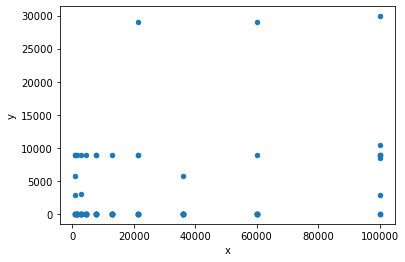

In [96]:
df = pd.concat({k: pd.Series(v) for k, v in newer_dict.items()}).reset_index().dropna()
df.columns = ["x", "ignore", "y"]
df["y"] = df["y"].astype(float)
df.plot(x="x", y="y", kind="scatter")

In [91]:
df["y"].shape

(100,)